# Preamble

In [1]:
from pytket.circuit.display import get_circuit_renderer
circuit_renderer = get_circuit_renderer()
circuit_renderer.set_render_options(zx_style=False)
circuit_renderer.set_render_options(crop_params=False)
circuit_renderer.save_render_options()
import networkx as nx
import numpy as np
from pytket.circuit import OpType
from pytket.circuit import Qubit, Circuit
from pytket.pauli import Pauli, QubitPauliString
from pytket.utils import QubitPauliOperator
def get_xxz_chain_hamiltonian(n_qubits: int, Delta_ZZ: float) -> QubitPauliOperator:
    sites = nx.path_graph(n_qubits)
    qpo_dict = {}
    for e in sites.edges:
        zz_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Z, Pauli.Z])
        xx_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.X, Pauli.X])
        yy_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Y, Pauli.Y])
        qpo_dict[zz_term] = Delta_ZZ
        qpo_dict[xx_term] = 1.0
        qpo_dict[yy_term] = 1.0
    return QubitPauliOperator(qpo_dict)
from pytket import Circuit
from sympy import symbols
from pytket.circuit.display import render_circuit_jupyter as draw
import numpy as np
n_system_qubits = 4
Delta_ZZ = 0.5
n_trotter_coherent = 5
t_trotterization = 10
xxz_hamiltonian = get_xxz_chain_hamiltonian(n_qubits=n_system_qubits, Delta_ZZ=Delta_ZZ)

# configure some visualisations
from pytket.circuit.display import get_circuit_renderer
circuit_renderer = get_circuit_renderer()
circuit_renderer.set_render_options(zx_style=False)
circuit_renderer.set_render_options(crop_params=False)
circuit_renderer.save_render_options()
from pytket.utils import QubitPauliOperator
from pytket.pauli import Pauli, QubitPauliString
import networkx as nx
from pytket.circuit import Qubit
from pytket import Circuit
from sympy import symbols
from pytket.circuit.display import render_circuit_jupyter as draw
from pytket.utils import gen_term_sequence_circuit
from pytket.passes import DecomposeBoxes
import numpy as np
def get_xxz_chain_hamiltonian(n_qubits: int, Delta_ZZ: float) -> QubitPauliOperator:
    sites = nx.path_graph(n_qubits)
    qpo_dict = {}
    for e in sites.edges:
        zz_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Z, Pauli.Z])
        xx_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.X, Pauli.X])
        yy_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Y, Pauli.Y])
        qpo_dict[zz_term] = Delta_ZZ
        qpo_dict[xx_term] = 1.0
        qpo_dict[yy_term] = 1.0
    return QubitPauliOperator(qpo_dict)
from pytket.extensions.qiskit import AerStateBackend 
import matplotlib.pyplot as plt
import qutip as qt
from qutip.qip.operations import hadamard_transform, phasegate
import scipy
#from matplotlib import pyplot as plt
from pytket.utils.expectations import get_operator_expectation_value
from pytket.extensions.qiskit import AerBackend
import time
import math,time,os,pickle,itertools,importlib,warnings
import matplotlib.pyplot as plt
import qutip as qt
from qutip.qip.operations import hadamard_transform, phasegate
import numpy as np
import scipy as sp

aer_sim = AerBackend()

#defining useful functions to get operators from strings
I,X,Y,Z,Had,S = qt.qeye(2),qt.sigmax(),qt.sigmay(),qt.sigmaz(),hadamard_transform(),phasegate(np.pi/2)
ket0,ket1=qt.basis(2,0),qt.basis(2,1)
def str2op(string):
    op_dict = {'I':I,'X':X,'Y':Y,'Z':Z,'H':Had,'S':S}
    assert type(string) == str or type(string) == list
    return qt.tensor([op_dict[p] for p in string])

### <u> Task 1: Construct Hamiltonian and Hamiltonian simulation circuit </u>

We implement a function which gives the quantum circuit for hamiltonian simulation for XXZ-type Hamiltonian.

In [2]:
def create_hamiltonian_circuit(c:Circuit, sys_reg, n_system_qubits:int, delta_t:float, Delta_ZZ: float) -> Circuit:
    """
    Create a circuit for Hamiltonian simulation using the Trotter-Suzuki approximation.

    Parameters:
    - n_system_qubits (int): Number of qubits in the system.
    - n_trotter_coherent (int): Number of Trotter steps.
 
    Returns:
    - circ (Circuit): The constructed pytket circuit.
    """
    
    for p in range(1, n_trotter_coherent + 1):
        for ind in range(n_system_qubits-1):
            # Calculate the angle for XX and YY phases
            angle = (delta_t * 2) / (np.pi * p)
            # Append XXPhase, YYPhase, and ZZPhase gates to the circuit
            c.XXPhase(angle, sys_reg[ind+1], sys_reg[ind])
            c.YYPhase(angle, sys_reg[ind+1], sys_reg[ind])
            c.ZZPhase(Delta_ZZ * angle, sys_reg[ind+1], sys_reg[ind])


### <u> Task 2: Construct the evolution uunder the dialated Lindblad operators $K_i$ </u>

Now, we add 2 ancillas, which will act as an enviroment on our system of 4 qubits. We create a circuit giving the action of jump operators according to the given defination.

In [3]:
n_ancilla_qubits = 2
n_system_qubits = n_system_qubits

circ = Circuit()
anc_reg = circ.add_q_register("ancilla", n_ancilla_qubits)
sys_reg = circ.add_q_register("system", n_system_qubits)

epsilon = 0.1  #CHECK WHAT THIS SHOULD BE

# Time step
Delta_t = 0.1  # Define appropriate value
alpha = ((Delta_t ** 0.5) * (2/np.pi) * np.sqrt(epsilon/2))  #REMOVED THE 1j term

# Implement time evolution under K_1
circ.add_gate(OpType.XXPhase, -alpha, [anc_reg[0], sys_reg[0]])
circ.add_gate(OpType.YYPhase, -alpha, [anc_reg[0], sys_reg[0]])

# Implement time evolution under K_2
circ.add_gate(OpType.XXPhase, -alpha, [anc_reg[1], sys_reg[n_system_qubits - 1]])
circ.add_gate(OpType.YYPhase, -alpha, [anc_reg[1], sys_reg[n_system_qubits - 1]])

# Reset ancilla qubits to trace them out
circ.add_gate(OpType.Reset, [anc_reg[0]])
circ.add_gate(OpType.Reset, [anc_reg[1]])

# Render circuit
draw(circ)

Now, we neatly combine everything in a function.

In [4]:
def create_dissipative_circuit(c, anc_reg, sys_reg, n_system_qubits: int, delta_t: float, epsilon: float) -> Circuit:
    """
    Create a circuit for simulating time evolution under dilated Lindblad operators K_1 and K_2.

    Parameters:
    - n_system_qubits (int): Number of qubits in the system.
    - Delta_t (float): Time step for each evolution.
    - epsilon (float): Parameter influencing the interaction strength.

    Returns:
    - Circuit: The constructed pytket circuit.
    """
    
    # Calculate alpha without the imaginary unit for gate compatibility
    alpha = (np.sqrt(delta_t) * (2/np.pi) * np.sqrt(epsilon/2))

    # Implement time evolution under K_1 and K_2 with their inverses
    pairs = [(anc_reg[0], sys_reg[0]), (anc_reg[1], sys_reg[n_system_qubits - 1])]
    for ancilla, system in pairs:
        # Apply the first set of gates
        c.add_gate(OpType.XXPhase, -alpha, [ancilla, system])
        c.add_gate(OpType.YYPhase, -alpha, [ancilla, system])


    # Reset ancilla qubits to trace them out
    for ancilla in anc_reg:
        c.add_gate(OpType.Reset, [ancilla])


### <u> Task 3: Building the full circuit </u>

Here we implement a complete circuit according to the formula 
\begin{equation*}
e^{M\Delta t \mathcal{L}} [\rho]
= \left( \prod_{i = 1}^M e^{\Delta t \mathcal{D}} \circ \mathcal{U}_{\Delta t} \right) [\rho] 
\,,
\quad \text{with} \quad
\mathcal{U}_{\Delta t} [\rho] = e^{-i\Delta t H} \rho e^{i\Delta t H} \,,
\end{equation*}

In [5]:
def full_sim(T, M, N, epsilon, Delta_ZZ) -> Circuit:

    delta_t = T/M
    full_circ = Circuit()
    n_ancilla_qubits = 2  # number of ancilla qubits required for the dissipative part
    anc_reg = full_circ.add_q_register("ancilla", n_ancilla_qubits)
    sys_reg = full_circ.add_q_register("system", N)
        
    for _ in range(M):
        create_hamiltonian_circuit(c = full_circ, sys_reg = sys_reg, n_system_qubits=N, delta_t = delta_t, Delta_ZZ = Delta_ZZ)
        create_dissipative_circuit(c = full_circ, anc_reg = anc_reg, sys_reg = sys_reg, n_system_qubits=N, delta_t = delta_t, epsilon = epsilon)

    return full_circ

However, we noticed that starting in the $|0\rangle ^{\otimes N}$ seems to not have any evolution effects. So we also do implementation using a state initialized in $|+\rangle |0\rangle^{\otimes N-1}$

In [6]:
def full_sim_with_Had(T, M, N, epsilon, Delta_ZZ) -> Circuit:

    delta_t = T/M
    full_circ = Circuit()
    n_ancilla_qubits = 2  # number of ancilla qubits required for the dissipative part
    anc_reg = full_circ.add_q_register("ancilla", n_ancilla_qubits)
    sys_reg = full_circ.add_q_register("system", N)
    full_circ.H(sys_reg[0])
        
    for _ in range(M):
        create_hamiltonian_circuit(c = full_circ, sys_reg = sys_reg, n_system_qubits=N, delta_t = delta_t, Delta_ZZ = Delta_ZZ)
        create_dissipative_circuit(c = full_circ, anc_reg = anc_reg, sys_reg = sys_reg, n_system_qubits=N, delta_t = delta_t, epsilon = epsilon)

    return full_circ
        

Now, just doing the sanity check to see that everything works properly.

In [7]:
T = 1
M = 1 #10
N = 4
epsilon = 0.1
Delta_ZZ = 0.5
circ = full_sim(T, M, N, epsilon, Delta_ZZ)
draw(circ)

Now, we vary the number of trotter steps and see how it affects the number of 2 qubit gates.

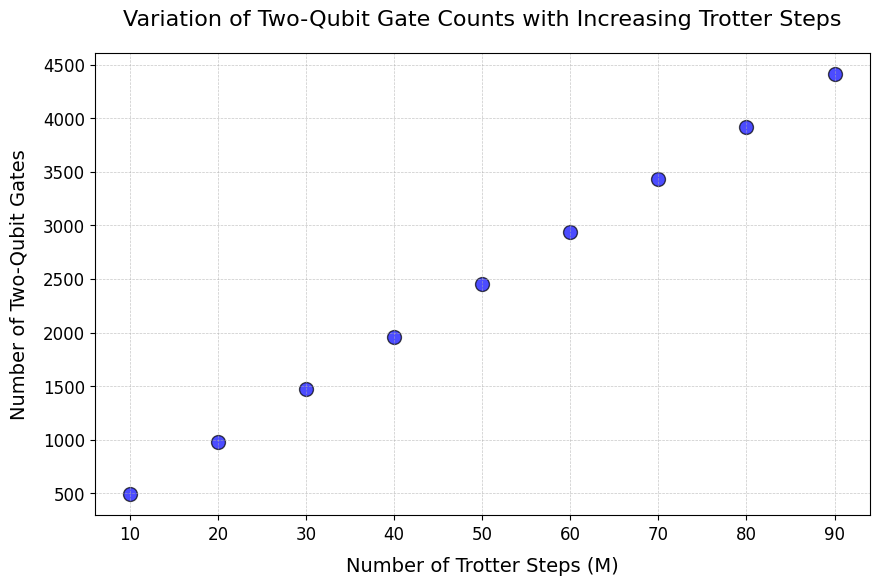

In [8]:
import matplotlib.pyplot as plt
from pytket.extensions.qiskit import AerBackend
n_gates = []
M_list = []
sv_backend = AerBackend()
for M_val in range(10, 100, 10):
    circ_new = full_sim(T=T, M=M_val, N=N, epsilon=epsilon, Delta_ZZ=Delta_ZZ)
    compiled_circuit = sv_backend.get_compiled_circuit(circ_new)
    n_gates.append(compiled_circuit.n_2qb_gates())
    M_list.append(M_val)
# Create the scatter plot
plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.scatter(M_list, n_gates, color='blue', s=100, edgecolor='black', alpha=0.7)  # Adjust point characteristics

# Adding labels and title with British English spelling
plt.xlabel('Number of Trotter Steps (M)', fontsize=14, labelpad=10)
plt.ylabel('Number of Two-Qubit Gates', fontsize=14, labelpad=10)
plt.title('Variation of Two-Qubit Gate Counts with Increasing Trotter Steps', fontsize=16, pad=20)

# Adding a grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Improve formatting of the plot
plt.xticks(fontsize=12)  # Enhance x-axis tick readability
plt.yticks(fontsize=12)  # Enhance y-axis tick readability

plt.show()

As we can see, the number of 2 qubit gates seems to be increasing linearly with number of trotter steps.

Now, let's output the density matrix and see everything is correct, and confirm it has unit trace.

In [9]:
from pytket.extensions.qiskit import AerDensityMatrixBackend

den_backend = AerDensityMatrixBackend()

# Run the circuit to get the density matrix
result_rho = den_backend.run_circuit(circ)
densitymx = result_rho.get_density_matrix()  # Retrieve the density matrix

print("Density Matrix:\n", densitymx)
print(np.trace(densitymx))

Density Matrix:
 [[ 1.00000000e+00-1.19468835e-33j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -1.80125244e-17+4.57812272e-34j
   5.77292630e-20+1.03614457e-18j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  5.77292630e-20-1.03614457e-18j
  -3.99150227e-18+3.99951119e-34j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 ...
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+

### <u> Task 4: Compute the steady state of the dissipative XXZ Heisenberg model </u>

We define a function to plot the spin profile, i.e., expectation value of $Z$ for each system qubit.

In [10]:
def plot_spin_profile(expectation_values, title='Spin Profile of the Quantum System', xlabel='Qubit Index', ylabel='Expectation Value of $Z^{(i)}$'):
    """
    Plots the spin profile of the quantum system.
    
    Args:
    expectation_values (list): A list of expectation values for each qubit.
    title (str): Title of the plot. Default is 'Spin Profile of the Quantum System'.
    xlabel (str): Label for the x-axis. Default is 'Qubit Index'.
    ylabel (str): Label for the y-axis. Default is 'Expectation Value of $Z^{(i)}$'.
    """
    N = len(expectation_values)  # Number of qubits or spin sites
    plt.figure(figsize=(10, 5))
    plt.plot(range(0, N), expectation_values, 'o-', color='skyblue')  # Using 'o-' to mark each point
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(range(0, N))  # Ensure x-ticks correspond to qubit indices
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()



Now, we will run the simulation, and get the denisty matrix.

In [11]:
import math,time,os,pickle,itertools,importlib,warnings
import matplotlib.pyplot as plt
import qutip as qt
from qutip.qip.operations import hadamard_transform, phasegate
import numpy as np
import scipy as sp

# Parameters
N_new = 4  # Number of qubits
T_new = 100 # Total simulation time
M_new = 30  # Number of Trotter steps
epsilon_new = 0.2  # Dissipative interaction strength
Delta_ZZ_new = 0.5  # ZZ interaction strength

# Prepare, run, and analyze
circuit_sim = full_sim(T=T_new, M=M_new, N=N_new, epsilon=epsilon_new, Delta_ZZ=Delta_ZZ_new)
circuit_sim_with_Had = full_sim_with_Had(T=T_new, M=M_new, N=N_new, epsilon=epsilon_new, Delta_ZZ=Delta_ZZ_new)

den_backend = AerDensityMatrixBackend()

result_rho = den_backend.run_circuit(circuit_sim)
result_rho_with_Had = den_backend.run_circuit(circuit_sim_with_Had)
densitymx = result_rho.get_density_matrix()
densitymx_with_Had = result_rho_with_Had.get_density_matrix()



Now using the density matrix from previous step, we will compute the expectation value with respect to single qubit Pauli Z operators.

In [12]:
I,X,Y,Z,Had,S = qt.qeye(2),qt.sigmax(),qt.sigmay(),qt.sigmaz(),hadamard_transform(),phasegate(np.pi/2)
ket0,ket1=qt.basis(2,0),qt.basis(2,1)

def str2op(string):
    op_dict = {'I':I,'X':X,'Y':Y,'Z':Z,'H':Had,'S':S}
    assert type(string) == str or type(string) == list
    return qt.tensor([op_dict[p] for p in string])

Z1 = str2op('IIZIII')
Z1 = Z1.full()
Z2 = str2op('IIIZII')
Z2 = Z2.full()
Z3 = str2op('IIIIZI')
Z3 = Z3.full()
Z4 = str2op('IIIIIZ')
Z4 = Z4.full()
Z5 = str2op('IIIIIIZ')
Z5 = Z5.full()

Z_list = [Z1, Z2, Z3, Z4]
expectation_values = []
x_vals = []

for idx, Z in enumerate(Z_list):
    expectation_values.append(np.trace(densitymx @ Z))
    x_vals.append(idx)

/opt/conda/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/conda/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


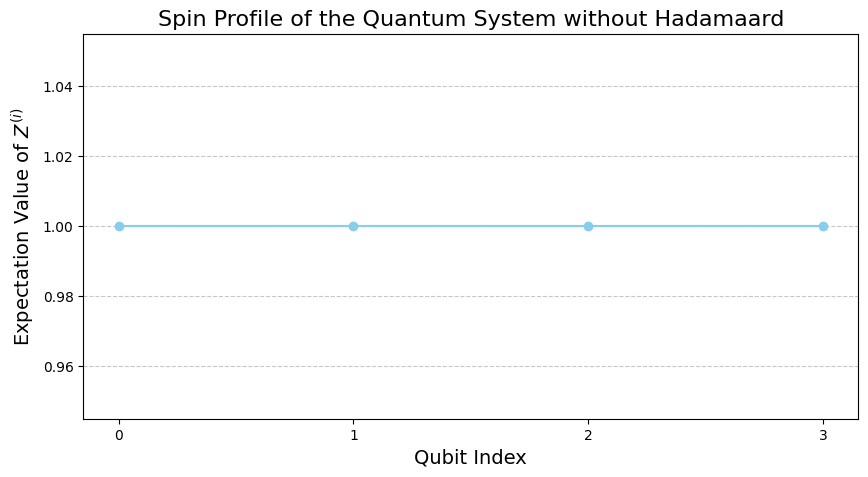

In [13]:
plot_spin_profile(expectation_values, title='Spin Profile of the Quantum System without Hadamaard')

This is the spin profile when starting in $|0\rangle^{\otimes N}$ state. Now, let's plot the spin profile when starting in the $|+\rangle |0\rangle^{\otimes N-1}$ state.

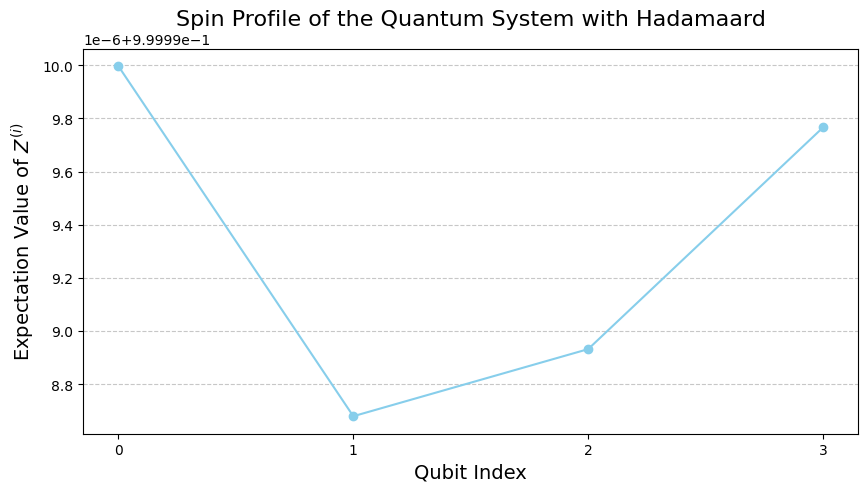

In [14]:
Z_list = [Z1, Z2, Z3, Z4]
expectation_values = []
x_vals = []

for idx, Z in enumerate(Z_list):
    expectation_values.append(np.trace(densitymx_with_Had @ Z))
    x_vals.append(idx)

plot_spin_profile(expectation_values, title='Spin Profile of the Quantum System with Hadamaard')

### <u> Task 5: Explore other parameter choices </u>

We tinker with parameters and plot the results. We see here how changing the trotter step affects the spin profile of our system.

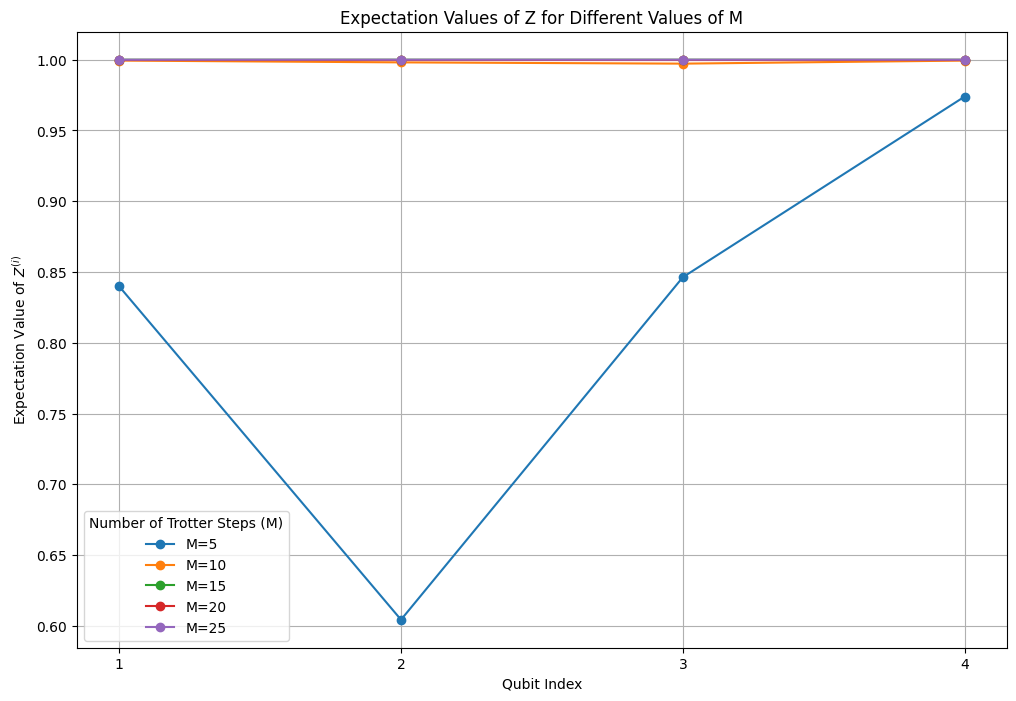

In [15]:
M_values = range(5, 30, 5)
expectation_values_by_M = {M: [] for M in M_values}
x_vals = range(0,4)

for M_val in M_values:
    circuit_sim_with_Had = full_sim_with_Had(T=T_new, M=M_val, N=N_new, epsilon=epsilon_new, Delta_ZZ=Delta_ZZ_new)
    result_rho_with_Had = den_backend.run_circuit(circuit_sim_with_Had)
    densitymx_with_Had = result_rho_with_Had.get_density_matrix()

    for Z in Z_list:
        exp_val = np.trace(densitymx_with_Had @ Z)
        expectation_values_by_M[M_val].append(np.real(exp_val))

plt.figure(figsize=(12, 8))

# Plotting data for each M
for M_val, exp_vals in expectation_values_by_M.items():
    plt.plot(range(1, N_new + 1), exp_vals, label=f'M={M_val}', marker='o')

plt.xlabel('Qubit Index')
plt.ylabel('Expectation Value of $Z^{(i)}$')
plt.title('Expectation Values of Z for Different Values of M')
plt.xticks(range(1, N_new + 1))
plt.legend(title='Number of Trotter Steps (M)')
plt.grid(True)
plt.show()
    

Now we vary the $\Delta_{ZZ}$ and see the impact.

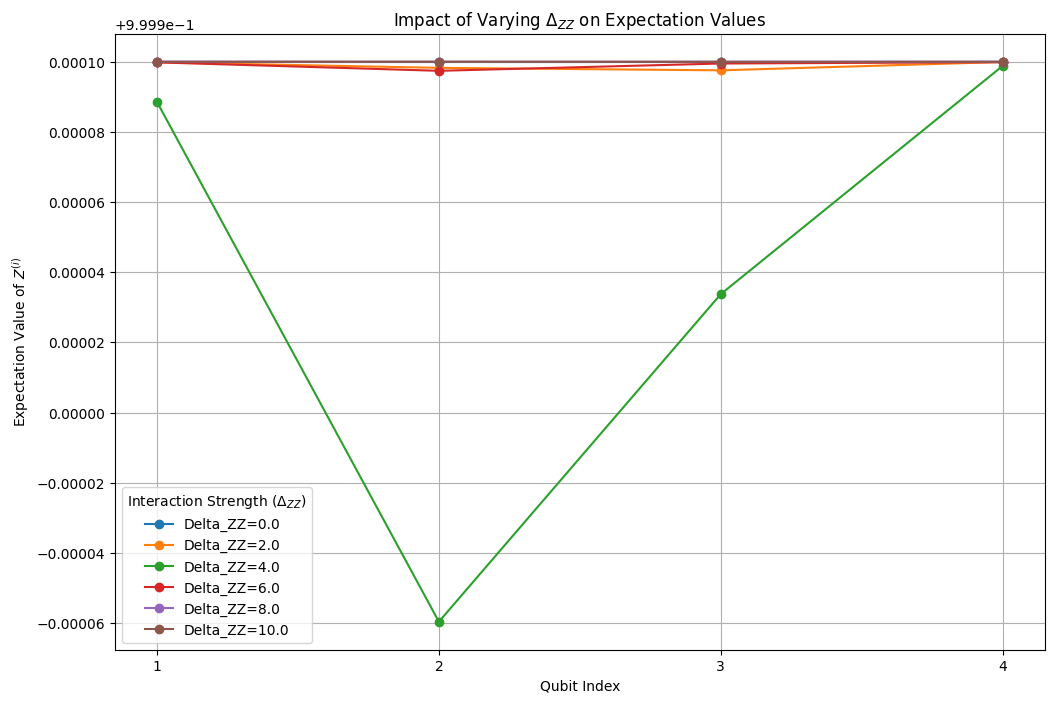

In [16]:
Delta_ZZ_values = np.linspace(0, 10, 6)  # Varying Delta_ZZ values

# Dictionary to store expectation values for each Delta_ZZ
expectation_values_by_Delta_ZZ = {Delta_ZZ: [] for Delta_ZZ in Delta_ZZ_values}

for Delta_ZZ in Delta_ZZ_values:
    # Generate the circuit and run the simulation
    circuit_sim_with_Had = full_sim_with_Had(T=T_new, M=M_new, N=N_new, epsilon=epsilon_new, Delta_ZZ=Delta_ZZ)
    result_rho_with_Had = den_backend.run_circuit(circuit_sim_with_Had)
    densitymx_with_Had = result_rho_with_Had.get_density_matrix()

    # Calculate expectation values for each Z operator
    for Z in Z_list:
        exp_val = np.trace(densitymx_with_Had @ Z)
        expectation_values_by_Delta_ZZ[Delta_ZZ].append(np.real(exp_val))

# Plotting
plt.figure(figsize=(12, 8))
for Delta_ZZ, exp_vals in expectation_values_by_Delta_ZZ.items():
    plt.plot(range(1, N_new + 1), exp_vals, label=f'Delta_ZZ={Delta_ZZ}', marker='o')

plt.xlabel('Qubit Index')
plt.ylabel('Expectation Value of $Z^{(i)}$')
plt.title('Impact of Varying $\\Delta_{ZZ}$ on Expectation Values')
plt.xticks(range(1, N_new + 1))
plt.legend(title='Interaction Strength ($\\Delta_{ZZ}$)')
plt.grid(True)
plt.show()

Now, we vary the $\epsilon$, i.e., change the system-bath interaction strength and see the effects.

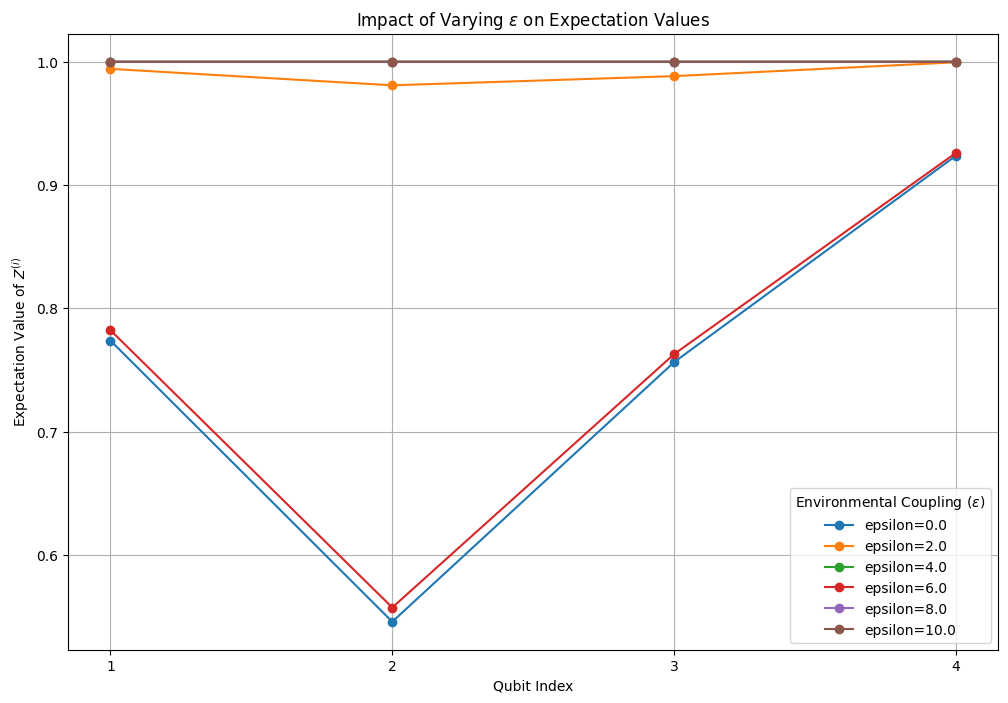

In [17]:
epsilon_values = np.linspace(0, 10, 6)  # Varying epsilon values

# Dictionary to store expectation values for each epsilon
expectation_values_by_epsilon = {epsilon: [] for epsilon in epsilon_values}

for epsilon in epsilon_values:
    # Generate the circuit and run the simulation
    circuit_sim_with_Had = full_sim_with_Had(T=T_new, M=M_new, N=N_new, epsilon=epsilon, Delta_ZZ=Delta_ZZ_new)
    result_rho_with_Had = den_backend.run_circuit(circuit_sim_with_Had)
    densitymx_with_Had = result_rho_with_Had.get_density_matrix()

    # Calculate expectation values for each Z operator
    for Z in Z_list:
        exp_val = np.trace(densitymx_with_Had @ Z)
        expectation_values_by_epsilon[epsilon].append(np.real(exp_val))

# Plotting
plt.figure(figsize=(12, 8))
for epsilon, exp_vals in expectation_values_by_epsilon.items():
    plt.plot(range(1, N_new + 1), exp_vals, label=f'epsilon={epsilon}', marker='o')

plt.xlabel('Qubit Index')
plt.ylabel('Expectation Value of $Z^{(i)}$')
plt.title('Impact of Varying $\\epsilon$ on Expectation Values')
plt.xticks(range(1, N_new + 1))
plt.legend(title='Environmental Coupling ($\\epsilon$)')
plt.grid(True)
plt.show()


### <u> Task 6: Comparison to Hamiltonian simulation </u>

Here, we compare the spin profile by doing the evolution under the coherent part, i.e, hamiltonian simulation

In [18]:
X1 = str2op('IIXIII')
X1 = X1.full()
X2 = str2op('IIIXII')
X2 = X2.full()
X3 = str2op('IIIIXI')
X3 = X3.full()
X4 = str2op('IIIIIX')
X4 = X4.full()

X_list = [X1, X2, X3, X4]

In [19]:
delta_t = 0.1
def ham_circ(N=4) -> Circuit:

    ham_circ = Circuit()
    sys_reg = ham_circ.add_q_register("system", N)
    ham_circ.H(sys_reg[0])
    create_hamiltonian_circuit(c=ham_circ, sys_reg = sys_reg, n_system_qubits=N, delta_t = delta_t, Delta_ZZ = Delta_ZZ)

    return ham_circ

In [20]:
only_ham_circ = ham_circ()
draw(only_ham_circ)

/opt/conda/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/conda/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


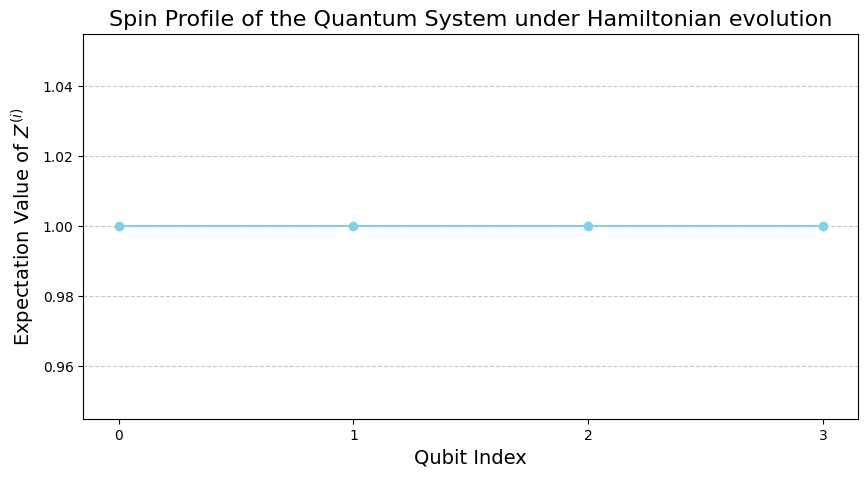

In [21]:
result_rho_ham = den_backend.run_circuit(only_ham_circ)
densitymx_ham = result_rho.get_density_matrix()
expectation_values = []
x_vals = []

for idx, Z in enumerate(Z_list):
    expectation_values.append(np.trace(densitymx_ham @ Z))
    x_vals.append(idx)

plot_spin_profile(expectation_values, title = 'Spin Profile of the Quantum System under Hamiltonian evolution')

These are the expectation values for individual Pauli Z. Now we will also see expectation values for inidividual Pauli X observables.

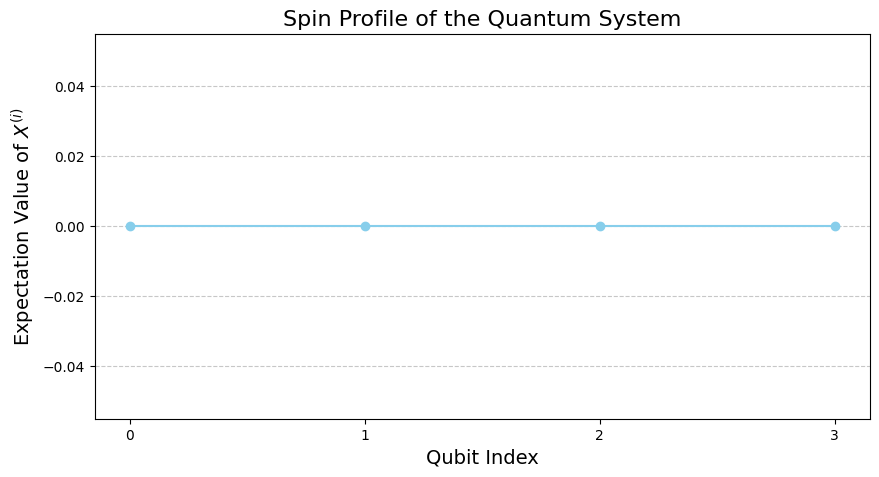

In [22]:
expectation_values = []
x_vals = []

for idx, X in enumerate(X_list):
    expectation_values.append(np.trace(densitymx_ham @ X))
    x_vals.append(idx)

plot_spin_profile(expectation_values, ylabel='Expectation Value of $X^{(i)}$')

The different between lindblad simulation verses the hamiltonian simulation shows that under the hamiltonian simulation, the state $|+\rangle|0\rangle^{\otimes N-1}$ seems to be preserved, whereas under lindblad simulation, the jump operators move the system around in the hilbert space, i.e., not keep it steady.

### <u> Task 11: Classical simulation </u>

Our goal is to apply shadow tomography to efficiently estimate the measurement outcomes of operators of a state $\rho(t)$. Directly measuring the state $\rho(t)$ of the system might not be feasible as it will disturb the state, and one has to possibly employ weak measurement methods, that will further complicate the process.
If, however, one has access to measurements of the initially prepared state ($\rho(0)$), with the knowledge of the noise model that defines the open system time evolution of $\rho$, one can use shadow tomography to estimate the measurement outcomes of local operators at time $t > 0$. 

Given a set of operators $\{O_n\}$, the expectation value of the $O_i$ at time $t$ is
$$
    \langle O_i \rangle(t) = \text{Tr}(O_i \rho(t)) = \text{Tr}(O_i \mathcal{L}_t[\rho(0)]) = \text{Tr}(\mathcal{L}_t^{\dagger}[O_i] \rho(0)) \, .
$$
where $\mathcal{L}_t[ \bullet ]$ is the Lindbladian describing the open system dynamics of the state $\rho$. If we intend to estimate $\langle O_i \rangle(t)$ from $\rho(0)$, we can compute $O_i(t)$ through Heisenberg picture time evolution of open system dynamics, and use shadow state tomography to ascertain $\langle O_i \rangle(t)$.

The reference [1] below gives the protocol of how to do efficient estimation of many observables, for a closed system, at a fixed time. We aim to extend that to open quantum system evolution for any time $t$.

[1] : https://arxiv.org/abs/2002.08953

We work with a simple dephasing model, defined as follows:

$$\mathcal{L}[\bullet] = -i[H, \bullet] + \sum_{i} \tilde{\gamma}_i \left(Z^{(i)} \bullet Z^{(i)} -\bullet  \right) \, .$$

We use QuTiP to define a $N=5$ qubit model where $H_S = \sum_i \omega_i Z^{(i)} + H_{\text{int}}$, with $\omega_i = \omega = -1/2$.  All qubits undergo $Z$-dephasing with strength $\tilde{\gamma_i} = \gamma =0.1$. 

there are two ways we can proceed, based on the equivalence between the Schrödinger and Heisenberg pictures
$$
\begin{align*}
    \langle O(t) \rangle = \text{Tr}(O\rho(t)) = \text{Tr}(O(t)\rho_0)\, .
\end{align*}
$$
We can replace $\rho$ with its shadow estimate to obtain
$$
\begin{align*}
    \langle O(t) \rangle = \mathbb{E}[\text{Tr}(O\hat{\rho}(t))] = \mathbb{E}[\text{Tr}(O(t)\hat{\rho}_0)]\, .
\end{align*}
$$

Now we build a model with Qutip.  The Lindblad ME in the Heisenberg picture is:

$$
\begin{align*}
    \dot{O}(t) &= \mathcal{L}^{\dagger}[O(t)] = i[H(t), O(t)] + \sum_{\alpha} \gamma_\alpha (L^{\dagger}_{\alpha}O(t)L_\alpha - \frac{1}{2}\{L^\dagger_{\alpha}L_\alpha , O(t) \})\\
    \dot{\vec{O}}(t) &= \Bigg( i(I \otimes H - H^T \otimes I) + \sum_\alpha \gamma_\alpha \Big( L_\alpha^T \otimes L_\alpha^\dagger - \frac{1}{2} \big( I \otimes L^\dagger_\alpha L_\alpha + (L^\dagger_\alpha L_\alpha)^T \otimes I \big) \Big) \Bigg) \vec{O}
\end{align*}
$$

where the second equation is after doing the vectorization.

In [23]:
N = 5 #number of qubits
Itot = str2op(['I']*N)  #total identity operator

########## BARE HAMILTONIAN ##########
w = -1/2 #energy of qubit
ws = [w]*N #uniform energies
# Hstrs = ['Z','Z','Z','Z']
Hstrs = ['Z']*N

H0 = 0
for iq in range(N):
    Hq = ['I']*N
    Hq[iq] = Hstrs[iq]
    H0 += ws[iq]*str2op(Hq)

########## INTERACTION HAMILTONIAN ##########

#4 qubits arranged in a loop 0 - 1 - 2 - 3 - 0 with pairwise ZZ couplings
interactions = [[['X',0],['X',1]],
                [['X',1],['X',2]],
                [['X',2],['X',3]],
                [['X',3],['X',4]],
                [['X',4],['X',0]]]

g = 0.01 #coupling strength
gs = [g]*len(interactions) #uniform interaction strength
Hint = 0
for it,term in enumerate(interactions):
    Hc = ['I']*N
    for op in term:
        Hc[op[1]] = op[0] 
    Hint += gs[it]*str2op(Hc)
    
########## LINDBLAD OPERATORS ##########
gamma = 0.1 #decay rate
gammas = [gamma]*N #uniform decay rate
# Lstrs = ['Z','Z','Z','Z']
Lstrs = ['Z']*N

Ls = []
for iq in range(N):
    Lq = ['I']*N
    Lq[iq] = Lstrs[iq]
    Ls.append(np.sqrt(gammas[iq])*str2op(Lq))

########## VECTORIZE LINDBLAD ##########
Ltot = 0
for L in Ls:
    Ltot += qt.sprepost(L.trans(),L.dag()) - 0.5*(qt.sprepost(Itot,L.dag()*L) + qt.sprepost((L.dag()*L).trans(),Itot))

TypeError: requires Qobj or QobjEvo operands

In [ ]:
import itertools
N = 4 #NUMBER OF QUBITS

########## DEFINE OBSERVABLES FOR SHADOW TOMOGRAPHY ##########
B = 2 #max weight of observables to consider

Ostrings = []
for weight in range(1,B+1): #error weight
# for weight in [2]: #error weight
    for loc in itertools.combinations(range(N),weight): #locations of error
        for err in list(itertools.product(['X','Y','Z'],repeat=weight)): #actual error
            O = ['I']*N
            for l,e in zip(loc,err):
                O[l] = e
            Ostrings.append(O)

Os = []
for Ostr in Ostrings:
    Os.append(qt.tensor([str2op(o) for o in Ostr]))

#convert strings to derandomized classical shadow form (DCS): [...,('X/Y/Z',<index>),...]
Ostrings2 = [([(k,ik) for ik,k in enumerate(Ostr) if k != 'I']) for Ostr in Ostrings]

print("# of observables:",len(Ostrings))
print(Ostrings[:10])

Unfortunately, due to time constraint, we did not get a chance to complete this implementation.